In [28]:
# ─────────── Imports (only once) ───────────
import os
import pandas as pd
import numpy as np
import ast
from rapidfuzz import process, fuzz
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_squared_error, r2_score

# ─────────── Load & Drop ───────────
df = pd.read_csv(os.path.join(os.getcwd(), "airbnbListingsData.csv"))
dropping_col = [ 'host_name',
 'host_location',
 'host_about',
 'host_response_rate',
 'host_acceptance_rate',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'n_host_verifications',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms', 'neighborhood_overview', 'name', 'description']
df.drop(columns=dropping_col, errors='ignore', inplace=True)

# ─────────── Missing Values ───────────
#   object→'Unknown', numeric→mean
for c in df.columns:
    if df[c].dtype == 'object':
        df[c].fillna('Unknown', inplace=True)
    else:
        df[c].fillna(df[c].mean(), inplace=True)

# ─────────── Price & Log-Transform ───────────
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['log_price'] = np.log1p(df['price'])

# ─────────── Amenities Normalize & Prune ───────────
df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
standard_amenities = {
    'wifi': ['wifi', 'fast wifi'],
    'tv': ['tv', 'hdtv', 'flat screen'],
    'streaming_services': ['netflix', 'hbo max', 'amazon prime video', 'apple tv', 'chromecast', 'roku'],
    'body_soap': ['body soap', 'bar soap', 'body wash'],
    'shampoo': ['shampoo'],
    'conditioner': ['conditioner'],
    'sound_system': ['sound system', 'bluetooth sound system', 'speaker'],
    'oven': ['oven', 'air fryer'],
    'stove': ['stove', 'gas stove', 'electric stove'],
    'workspace': ['workspace', 'monitor', 'desk', 'office chair'],
    'refrigerator': ['refrigerator', 'fridge', 'mini fridge'],
    'parking': ['parking', 'garage', 'driveway'],
    'children_amenities': ['children', 'books and toys', 'crib', 'baby bath'],
    'gym': ['gym', 'fitness'],
    'pool': ['pool', 'rooftop pool', 'heated pool']
}
def normalize(a):
    a = a.lower()
    for cat, kws in standard_amenities.items():
        match, score, _ = process.extractOne(a, kws, scorer=fuzz.partial_ratio) or (None, 0, None)
        if score > 80:
            return cat
    return None

df['norm_amenities'] = df['amenities'].apply(lambda L: {normalize(a) for a in L if normalize(a)})

# Build binary columns for the 20 most common normalized amenities
all_norms = set().union(*df['norm_amenities'])
amen_df = pd.DataFrame([{n: int(n in norms) for n in all_norms} for norms in df['norm_amenities']])
freq    = amen_df.sum().sort_values(ascending=False)
top20   = freq.index[:20]
amen_df = amen_df[top20]                            # keep just top 20
df['amenity_count'] = amen_df.sum(axis=1)
df = pd.concat([df, amen_df], axis=1)

# ─────────── One-Hot & Boolean Encode ───────────
df = pd.get_dummies(df, columns=['neighbourhood_group_cleansed','room_type'])
bools = df.select_dtypes(include='bool').columns
for b in bools:
    df[b] = LabelEncoder().fit_transform(df[b])

# ─────────── Final Cleanup ───────────
# drop raw columns no longer needed
df.drop(columns=['amenities','norm_amenities','price'], inplace=True)

# ─────────── Train/Test Split & Model ───────────
X = df.drop(columns='log_price')
y = df['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)



# print("Training RandomForest…")
# rf = RandomForestRegressor(n_estimators=200, random_state=1234)
# rf.fit(X_train, y_train)
# preds = rf.predict(X_test)

# print("RMSE (log):", np.sqrt(mean_squared_error(y_test, preds)))
# print("R² (log):",  r2_score(y_test, preds))

# ────────── Hyperparameter Tuning ──────────
print("Tuning RandomForest…")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=1234),
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
preds = best_rf.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("RMSE (log):", np.sqrt(mean_squared_error(y_test, preds)))
print("R² (log):", r2_score(y_test, preds))


<>:37: SyntaxWarning:

invalid escape sequence '\$'

<>:37: SyntaxWarning:

invalid escape sequence '\$'

/var/folders/4t/l3mnmq850bzd4m_pcjfl707c0000gn/T/ipykernel_6059/1269811024.py:37: SyntaxWarning:

invalid escape sequence '\$'

/var/folders/4t/l3mnmq850bzd4m_pcjfl707c0000gn/T/ipykernel_6059/1269811024.py:34: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/4t/l3mnmq850bzd4m_pcjfl707c0000gn/T/ipykernel_6059/1269811024.py:32: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through c

Tuning RandomForest…
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RMSE (log): 0.3723317032977843
R² (log): 0.7123257989561489


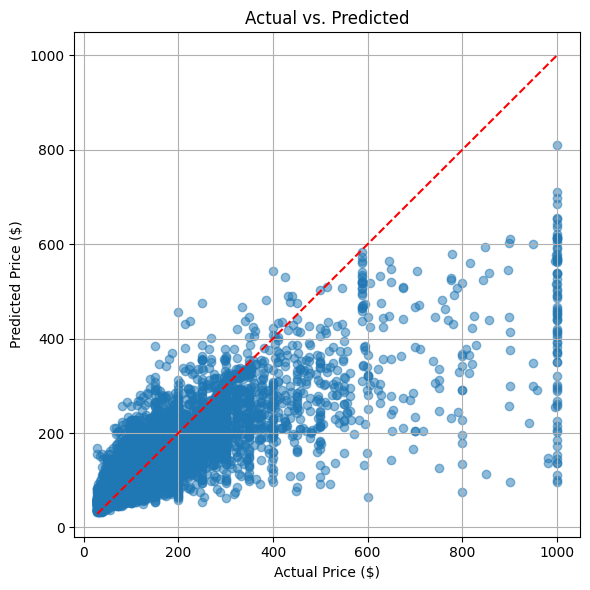

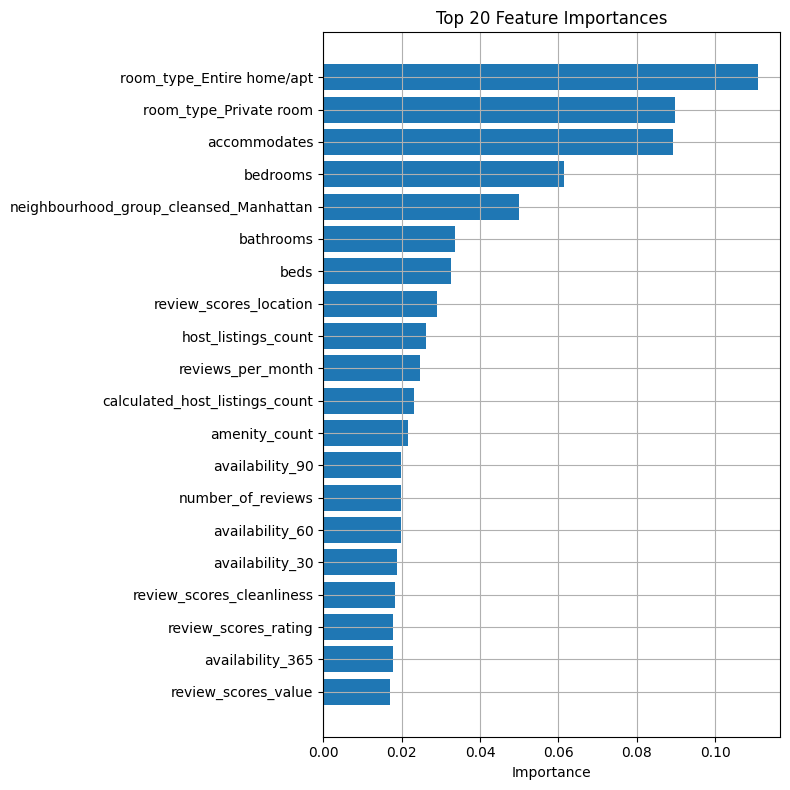

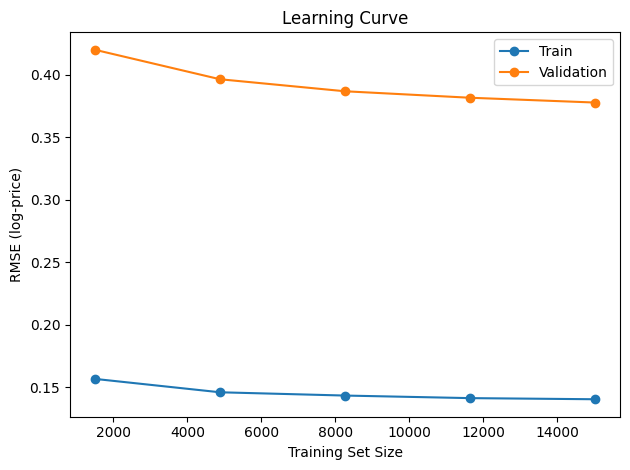

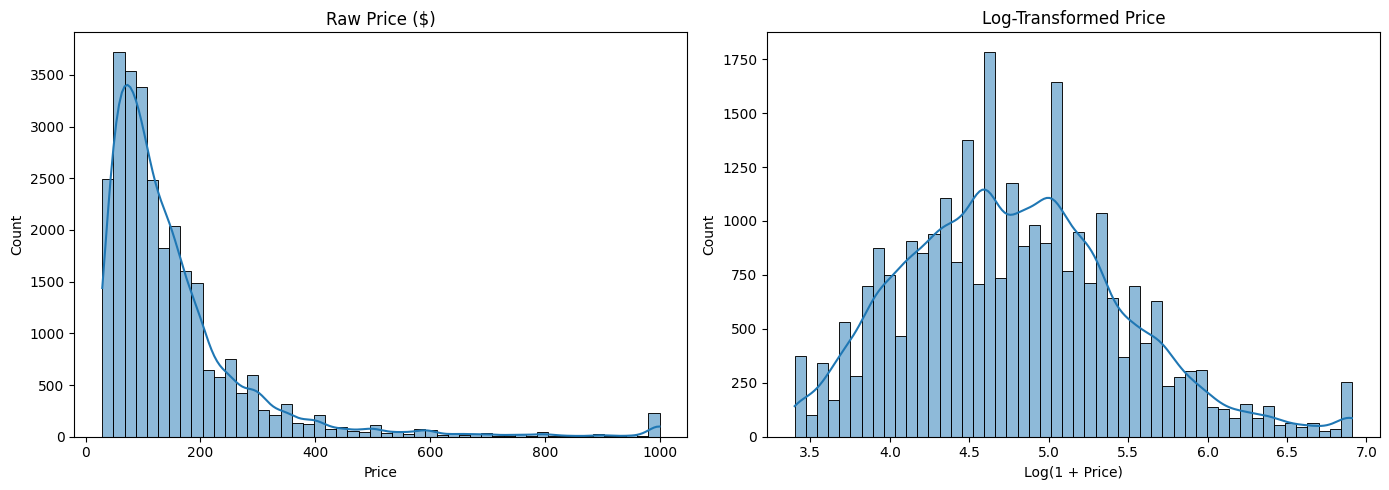

/var/folders/4t/l3mnmq850bzd4m_pcjfl707c0000gn/T/ipykernel_6059/2748722270.py:126: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/4t/l3mnmq850bzd4m_pcjfl707c0000gn/T/ipykernel_6059/2748722270.py:130: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




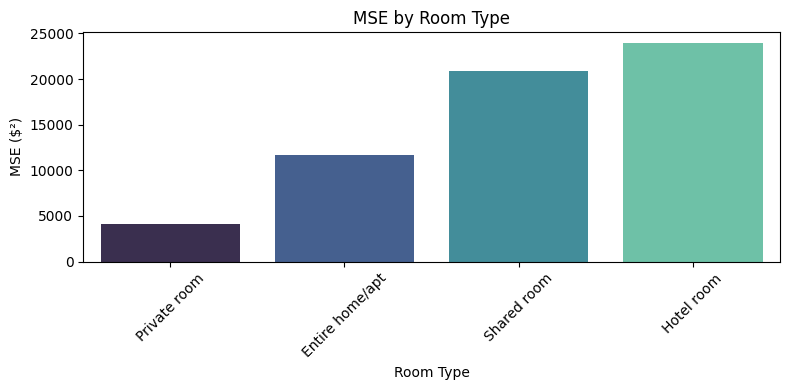

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import plotly.express as px

# assume best_rf, X_train, X_test, y_train, y_test, df are already defined

preds = best_rf.predict(X_test)

# Actual vs. Predicted
plt.figure(figsize=(6, 6))
plt.scatter(np.expm1(y_test), np.expm1(preds), alpha=0.5)
plt.plot(
    [np.expm1(y_test).min(), np.expm1(y_test).max()],
    [np.expm1(y_test).min(), np.expm1(y_test).max()],
    "r--"
)
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Top 20 Feature Importances
importances = best_rf.feature_importances_
idx = np.argsort(importances)[-20:]
plt.figure(figsize=(8, 8))
plt.barh(X.columns[idx], importances[idx])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances")
plt.grid(True)
plt.tight_layout()
plt.show()

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_rf,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1,
    shuffle=True,
    random_state=1234
)
train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-val_scores.mean(axis=1))
plt.plot(train_sizes, train_rmse, "o-", label="Train")
plt.plot(train_sizes, val_rmse, "o-", label="Validation")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE (log-price)")
plt.legend()
plt.title("Learning Curve")
plt.tight_layout()
plt.show()

# Price Distribution Before and After Log
raw_price = np.expm1(df["log_price"])
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(raw_price, bins=50, kde=True, ax=axes[0])
axes[0].set_title("Raw Price ($)")
axes[0].set_xlabel("Price")
sns.histplot(df["log_price"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Log-Transformed Price")
axes[1].set_xlabel("Log(1 + Price)")
plt.tight_layout()
plt.show()

# MSE Cost Surface on amenity_count → log_price
x = X_train["amenity_count"].values
y = y_train.values
def compute_mse(w, b):
    return mean_squared_error(y, w * x + b)
w_range = np.linspace(-1, 1, 100)
b_range = np.linspace(y.min(), y.max(), 100)
W, B = np.meshgrid(w_range, b_range)
Z = np.zeros_like(W)
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        Z[i, j] = compute_mse(W[i, j], B[i, j])
fig = go.Figure()
fig.add_trace(go.Surface(x=W, y=B, z=Z, colorscale="Plasma", showscale=True))
fig.update_layout(
    title="MSE Cost Surface on amenity_count → log_price",
    scene=dict(xaxis_title="slope (w)", yaxis_title="intercept (b)", zaxis_title="MSE"),
    width=800, height=600
)
fig.show()

# MSE Cost Surface on bedrooms → log_price
def plot_cost_surface(feature, w_min, w_max):
    x = X_train[feature].values
    y = y_train.values
    def mse(w, b):
        return mean_squared_error(y, w * x + b)
    W, B = np.meshgrid(
        np.linspace(w_min, w_max, 100),
        np.linspace(y.min(), y.max(), 100)
    )
    Z = np.vectorize(mse)(W, B)
    fig = go.Figure()
    fig.add_trace(go.Surface(x=W, y=B, z=Z, colorscale="Plasma", showscale=True))
    fig.update_layout(
        title=f"MSE Cost Surface on {feature} → log_price",
        scene=dict(xaxis_title="slope (w)", yaxis_title="intercept (b)", zaxis_title="MSE"),
        width=800, height=600
    )
    fig.show()

plot_cost_surface("bedrooms", w_min=-5, w_max=5)

# MSE by Room Type
results = X_test.copy()
results["actual"] = np.expm1(y_test)
results["pred"] = np.expm1(preds)
room_cols = [c for c in X_test.columns if c.startswith("room_type_")]
results["room_type"] = (
    X_test[room_cols].idxmax(axis=1).str.replace("room_type_", "")
)
mse_by_type = results.groupby("room_type").apply(
    lambda df: mean_squared_error(df["actual"], df["pred"])
).sort_values()
plt.figure(figsize=(8, 4))
sns.barplot(x=mse_by_type.index, y=mse_by_type.values, palette="mako")
plt.xlabel("Room Type")
plt.ylabel("MSE ($²)")
plt.title("MSE by Room Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Linked Scatter Matrix of Key Features
df_results = X_test.copy()
df_results["actual"] = np.expm1(y_test)
df_results["predicted"] = np.expm1(preds)
df_results["error"] = df_results["predicted"] - df_results["actual"]
room_types = results["room_type"]
dims = ["amenity_count", "number_of_reviews", "bedrooms", "bathrooms", "error"]
fig1 = px.scatter_matrix(df_results, dimensions=dims, color=room_types)
fig1.update_layout(width=800, height=800, title="Linked Scatter Matrix")
fig1.show()

# Amenities Treemap
amen_cols = [c for c in standard_amenities if c in X_test.columns]
amen_melt = (
    df_results.reset_index()[["index", "actual"]]
    .merge(
        X_test[amen_cols]
        .reset_index()
        .melt(
            id_vars=["index"],
            value_vars=amen_cols,
            var_name="amenity",
            value_name="has_amenity",
        ),
        on="index",
    )
    .query("has_amenity == 1")
)
amen_summary = (
    amen_melt.groupby("amenity")
    .agg(count=("has_amenity", "count"), avg_price=("actual", "mean"))
    .reset_index()
)
fig2 = px.treemap(
    amen_summary,
    path=["amenity"],
    values="count",
    color="avg_price",
    color_continuous_scale="Viridis",
    title="Amenities Treemap",
)
fig2.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig2.show()
